# Feature selection analysis

In this notebook, several feature sets are investigated, depending on several criteria such as R2 score or MAE.

### Importing necessary libraries

In [10]:
import json
import copy
import os
from typing import List
from sklearn.model_selection import train_test_split
from ml_tools.analyzers import Reader, Writer
from ml_tools.plots import FeatureImportancePlotter
from ml_tools.predictor import Predictor
from ml_tools.helpers import create_simulation, get_processed_data_from_csv
from ml_tools.trainer import Trainer
from config import FeatureConfigReader, ModelsConfig, Config


### Define paths to JSON and CSV Files

To set up the models and each feature used in the investigation, JSON config files are used.

The main data file is [data_P3.csv](CSV_files/data_P3.csv).

- **"[feature_selection.json](config/feature_selection.json)":** Used this file to define the simulation for all pair combinations between one feature and one ML algorithm. 
- **"[features.json](config/features.json)":** Used to define different feature selection combinations.
- **"[models.json](config/models.json)":** Used to define different ML algorithms employed in this project, specifically "Linear Regression" and "K Nearest Neighbours," along with lables for associated plots.
- **"[data_P3.csv](CSV_files/data_P3.csv)":** Contains damage index simulation results.

In [11]:
# File paths
feature_selection_config_file_name = os.path.join("config", "feature_selection.json")
features_config_file_name = os.path.join("config", "features.json")
models_config_file_name = os.path.join("config", "models.json")
data_file_name = os.path.join("CSV_files", "data_P3.csv")
results_file_name = "results_feature_selection"

### Creating a general configuration file for investigated simulation experiments

For each model-feature pair, a configuration is developed.

In [12]:
# Configuration stage
models_config = ModelsConfig(models_config_file_name)
base_models = models_config.get_model_names()

features_config = FeatureConfigReader(features_config_file_name)

features = features_config.get_features("all_features")

# Define the static portions of your simulation configurations
base_simulation = {
    "description": 'feature selection',
    "features": [],
    "model": {
        "type": "",
        "hyper_parameters": {}
    }
}

 Since multiple models and feature sets are investigated, an additional configuration file containing parameters for all simulation scenarios is devleoped.

In [13]:
# Initialize the dictionary to hold all simulations
all_simulations = {"simulations": {}}

simulation_count = 1
for feature in features:
    for model in base_models:
        # Create a deep copy of the base_simulation dictionary
        current_simulation = create_simulation(base_simulation, [feature], model, "no_hyper_params", models_config )
        
        all_simulations["simulations"][f"simulation {simulation_count}"] = current_simulation
        
        simulation_count += 1

with open(feature_selection_config_file_name, "w") as f:
    json.dump(all_simulations, f, indent=4)

### Training and testing models on the previously configured scenarios

The results are saved in **"[results_feature_selection.csv](results_feature_selection.csv)"**. 

In this file we can see the performances obtained with all ML algorithms run for every individual feature.

In [14]:
processed_data = get_processed_data_from_csv(data_file_name)

y = processed_data['DI_cladire'] 

config = Config(feature_selection_config_file_name)

simulations = config.get_simulations()

readers: List[Reader] = []
for simulation in simulations:

    selected_features = config.get_features(simulation)
    x = processed_data[selected_features]
    model_type = config.get_model_type(simulation)
    hyper_params = config.get_hyper_parameters(simulation)
    
    trainer = Trainer(x, y, model_type, hyper_params)
    trainer.set_train_test_data(test_size=0.2)
    trainer.train_model()
    
    predictor = Predictor(trainer)
    predictor.set_prediction_on_test()
    predictor.set_prediction_on_train()

    reader = Reader(simulation, trainer, predictor)
    readers.append(reader)
    reader.set_performances_on_test_data()
    reader.set_performances_on_train_data()

    print("---------------------------")
    reader.print_performances()
    writer = Writer(config, simulation,reader.performances, results_file_name)
    writer.append_to_csv()


---------------------------
Linear regression: MAE (test): 0.37 | MSE (test): 0.24 | R2 (test): 0.02 | MAE (train): 0.37 | MSE (train): 0.23 | R2 (train): 0.02 | 
---------------------------
K Nearest Neighbours: MAE (test): 0.39 | MSE (test): 0.25 | R2 (test): -0.03 | MAE (train): 0.38 | MSE (train): 0.24 | R2 (train): -0.03 | 
---------------------------
Linear regression: MAE (test): 0.37 | MSE (test): 0.24 | R2 (test): 0.02 | MAE (train): 0.37 | MSE (train): 0.23 | R2 (train): 0.01 | 
---------------------------
K Nearest Neighbours: MAE (test): 0.38 | MSE (test): 0.25 | R2 (test): -0.03 | MAE (train): 0.38 | MSE (train): 0.24 | R2 (train): -0.03 | 
---------------------------
Linear regression: MAE (test): 0.33 | MSE (test): 0.2 | R2 (test): 0.19 | MAE (train): 0.33 | MSE (train): 0.19 | R2 (train): 0.18 | 
---------------------------
K Nearest Neighbours: MAE (test): 0.29 | MSE (test): 0.17 | R2 (test): 0.31 | MAE (train): 0.25 | MSE (train): 0.13 | R2 (train): 0.44 | 
----------

### Plotting performances

In this section, we plot the MAE and R2 performances that were obtained with all ML algorithms for every individual feature. 

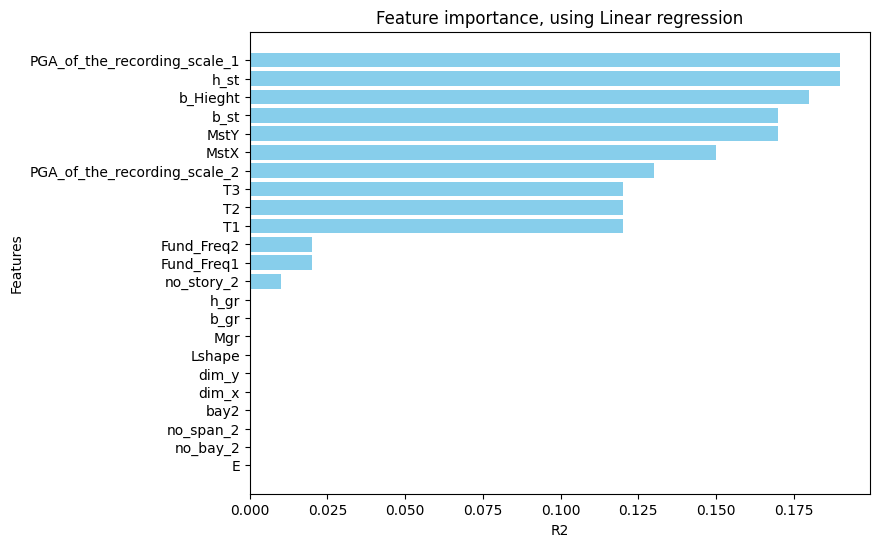

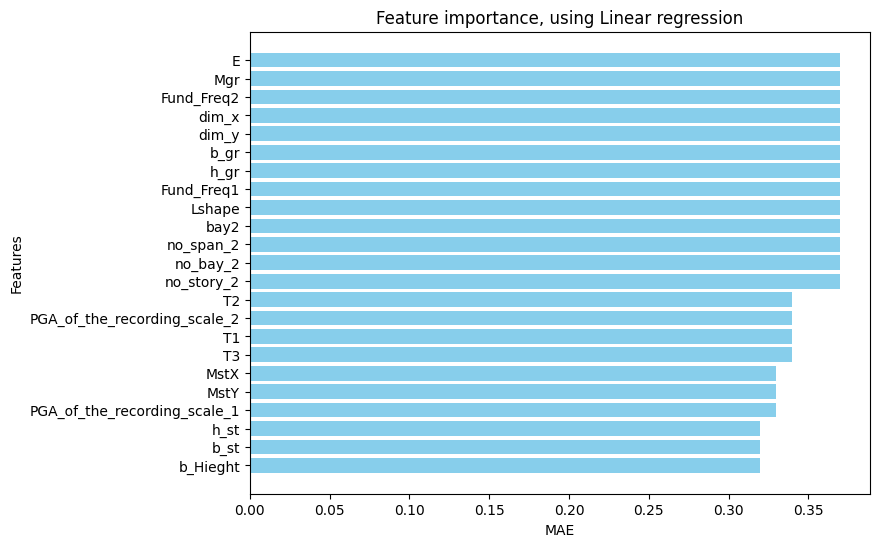

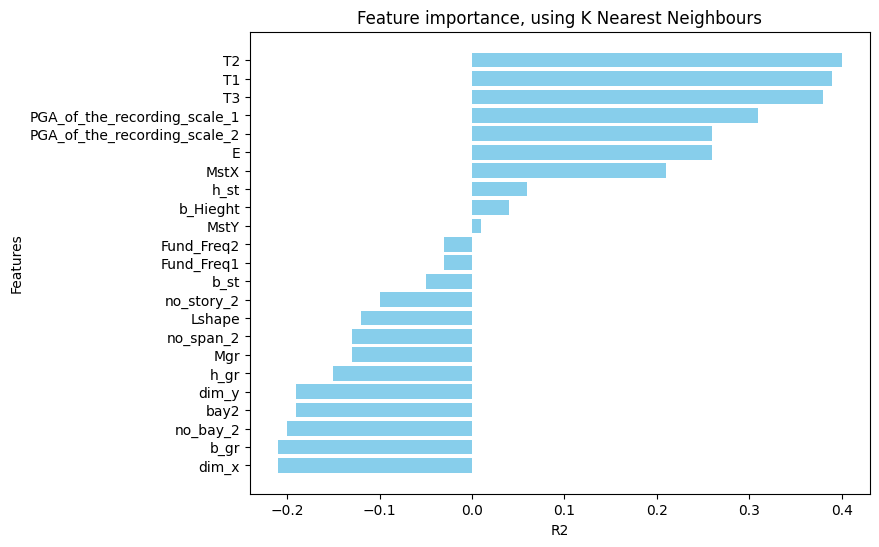

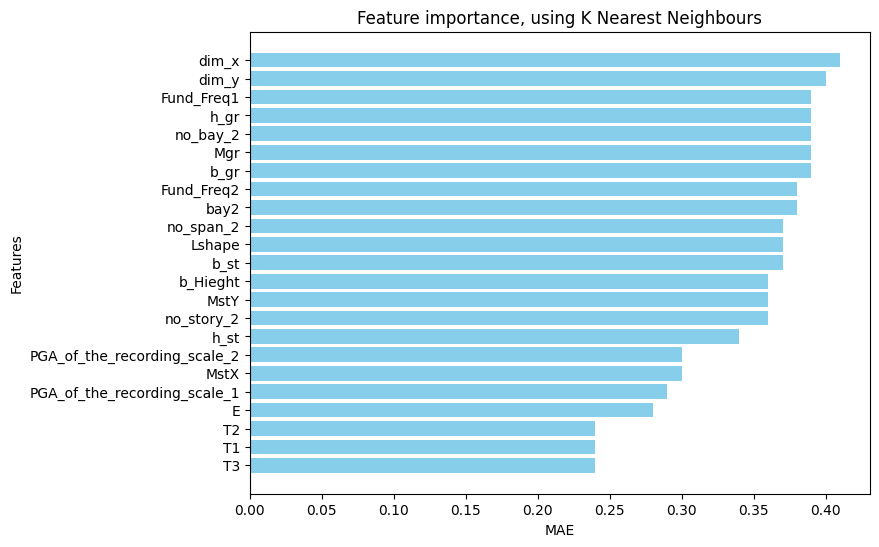

In [15]:
indicators = ["R2", "MAE"]
models = [reader.trainer.model_type for reader in readers]

performances_by_indicator_by_model = {}
for indicator in indicators:
    performances_by_indicator_by_model[indicator] = {model: [] for model in models  }

for reader in readers:
    model = reader.trainer.model_type
    for indicator in indicators:
        performance =[performance.value for performance in reader.performances if performance.indicator == indicator and performance.data_type == "test" and reader.trainer.model_type == str(performance.model)][0]
        performances_by_indicator_by_model[indicator][model].append(performance)

for model in base_models :
    for indicator in indicators:
        plotter = FeatureImportancePlotter(config,"figs", False, features, performances_by_indicator_by_model[indicator][model], indicator, model)
        plotter.generate_plot()